In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits

In [2]:
data = Table.read("allStarCannon-l31c.2.fits")
apogee = fits.open("allStar-l31c.2.fits")

In [3]:
apogee = apogee[1].data
print(apogee.dtype.names)

('APSTAR_ID', 'TARGET_ID', 'ASPCAP_ID', 'FILE', 'APOGEE_ID', 'TELESCOPE', 'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'APOGEE_TARGET1', 'APOGEE_TARGET2', 'APOGEE_TARGET3', 'TARGFLAGS', 'SURVEY', 'NINST', 'NVISITS', 'COMBTYPE', 'COMMISS', 'SNR', 'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR', 'VERR_MED', 'OBSVHELIO_AVG', 'OBSVSCATTER', 'OBSVERR', 'OBSVERR_MED', 'SYNTHVHELIO_AVG', 'SYNTHVSCATTER', 'SYNTHVERR', 'SYNTHVERR_MED', 'RV_TEFF', 'RV_LOGG', 'RV_FEH', 'RV_ALPHA', 'RV_CARB', 'RV_CCFWHM', 'RV_AUTOFWHM', 'SYNTHSCATTER', 'STABLERV_CHI2', 'STABLERV_RCHI2', 'CHI2_THRESHOLD', 'STABLERV_CHI2_PROB', 'APOGEE2_TARGET1', 'APOGEE2_TARGET2', 'APOGEE2_TARGET3', 'MEANFIB', 'SIGFIB', 'SNREV', 'APSTAR_VERSION', 'ASPCAP_VERSION', 'RESULTS_VERSION', 'EXTRATARG', 'MIN_H', 'MAX_H', 'MIN_JK', 'MAX_JK', 'PARAM', 'FPARAM', 'PARAM_COV', 'FPARAM_COV', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'VMICRO', 'VMACRO', 'VSINI', 'M_H

In [4]:
from collections import Counter
fields = np.array([each.strip() for each in apogee["FIELD"]])
counter_fields = Counter(fields)

print("\n".join(sorted(set(fields))))

cluster_candidate_fields = {}
for k, v in counter_fields.items():
    if k.startswith(("M", "N", "P")):
        cluster_candidate_fields[k] = v
        print(k, v)

print("Sum: {}".format(sum(cluster_candidate_fields.values())))

000+02
000+04
000+06
000+08
000+10
000+12
000+14
000+16
000+30
000+45
000+60
000+75
000-02
001+01
001-01
002+00
002+04
002+06
002-04
003+02
003+05
003-05
004+00
004+02
004+04
004-02
004-04
005+03
005-03
006+00
006+02
006+06
006-02
007+07
008+00
008+02
008-02
009+09
010+00
010+02
010+60
010-02
012+00
012+02
012-02
014+00
014+02
014+89_MGA
014-02
015+30
016+00
016+02
016+77_MGA
016-02
018+00
018+02
018-02
020+00
020+02
020+06
020+12
020+60
020-02
022+00
022+02
022-02
023+88_MGA
024+00
024+03
024-03
025+12
025-12
027+00
027+04
027-04
030+00
030+04
030+08
030+12
030+30
030+60
030+75
030-04
030-08
030-12
032+81_MGA
034+00
034+06
034+12
034-12
037+79_MGA
038+00
038+04
038-04
040+43_MGA
040+45
040+60
040+88_MGA
044+42_MGA
044+54_MGA
045+00
045+06
045+12
045+30
045+42_MGA
045-06
045-12
046+48
047+52_MGA
047-25_MGA
048+44_MGA
048+88_MGA
049+00
049+06
049+12
049+46_MGA
049+62
049+88_MGA
049-12
050+31_MGA
050+60
050+63_MGA
050-29_MGA
052+44_MGA
052-33_MGA
053+00
053+04
053+58_MGA
053-04
054-35_MG

/home/acas0005/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


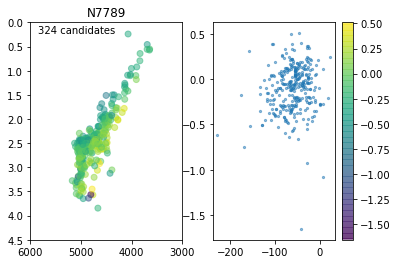

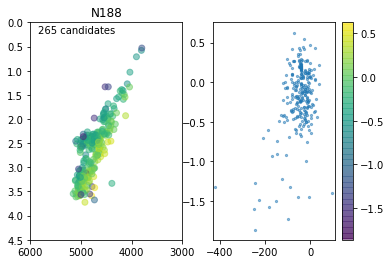

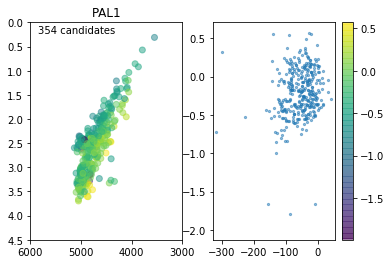

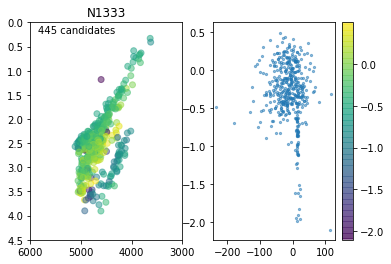

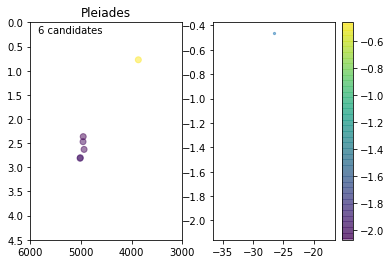

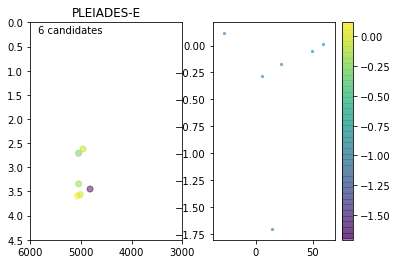

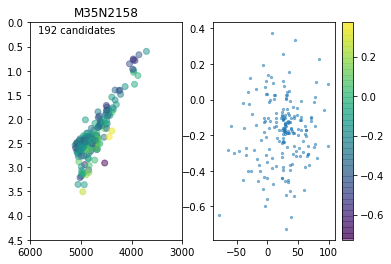

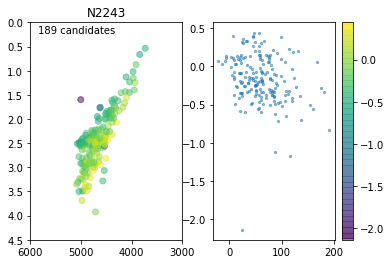

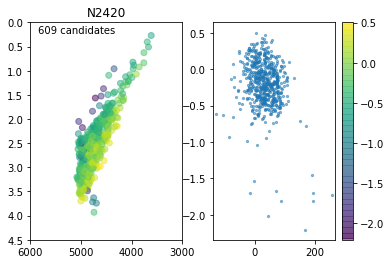

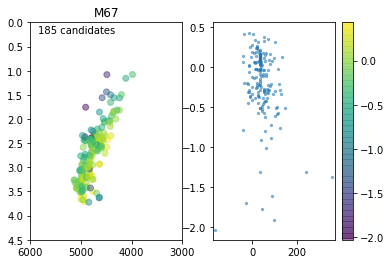

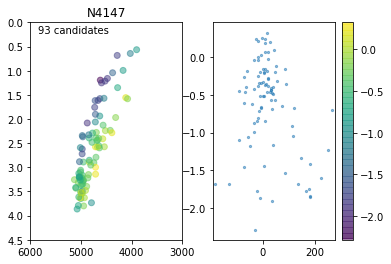

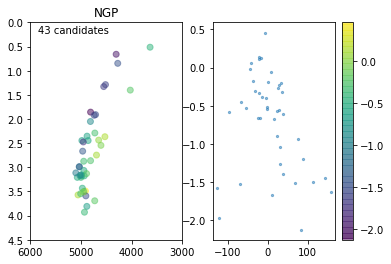

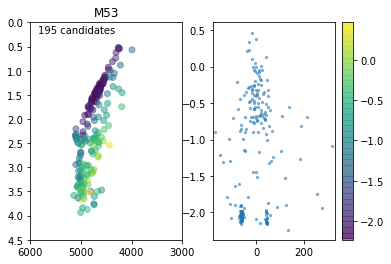

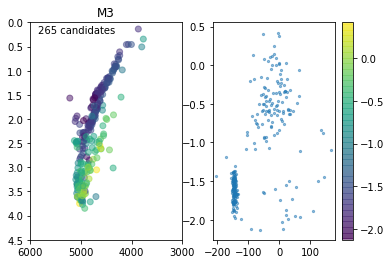

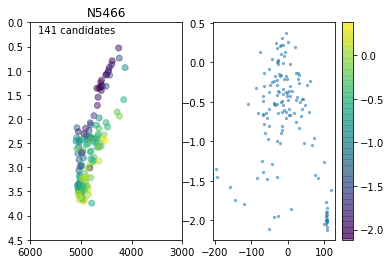

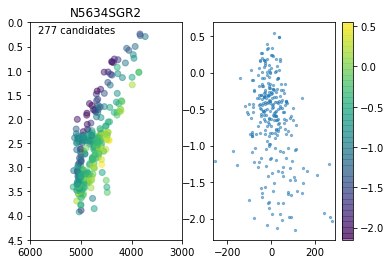

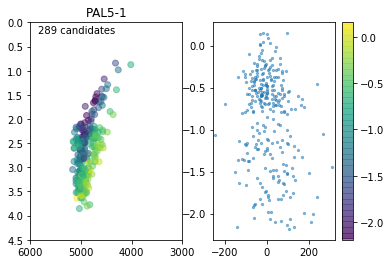

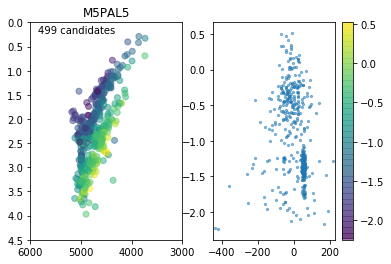

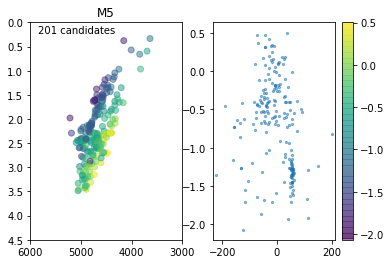

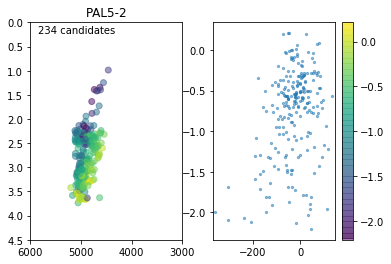

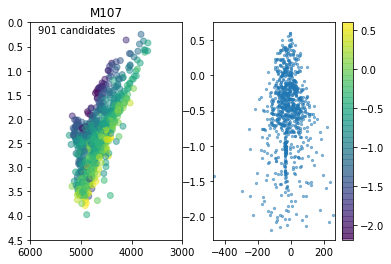

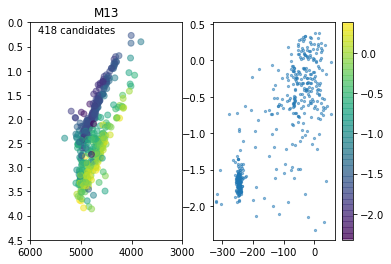

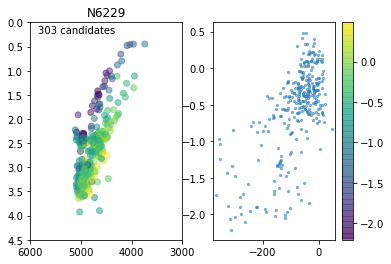

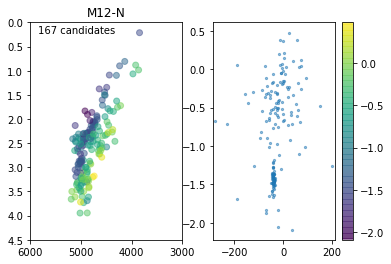

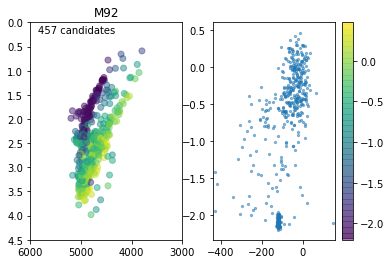

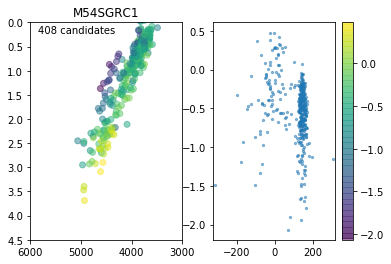

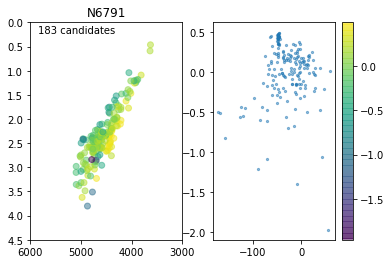

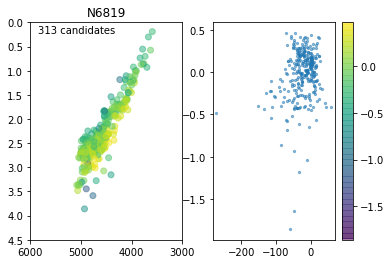

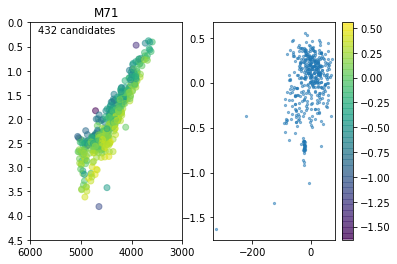

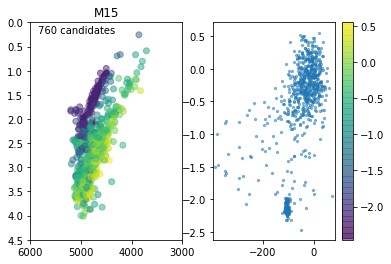

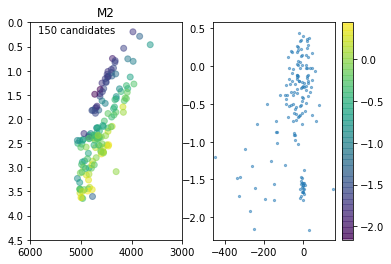

In [5]:
bad = data["TEFF"] < 0
for k in ("TEFF", "LOGG", "FE_H"):
    data[k][bad] = np.nan

# Plot and cull.
for cluster_name, num_candidates in cluster_candidate_fields.items():
    candidate = (fields == cluster_name) * np.isfinite(data["TEFF"])
    if candidate.sum() < 2:
        continue
        
    
    fig, axes = plt.subplots(1, 2)
    
    axes[0].set_title(cluster_name)
    scat = axes[0].scatter(data["TEFF"][candidate], data["LOGG"][candidate], c=data["FE_H"][candidate],
                          alpha=0.5)

    axes[0].set_xlim(6000, 3000)
    axes[0].set_ylim(4.5, 0)
    
    axes[0].text(0.05, 0.95, "{} candidates".format(candidate.sum()), transform=axes[0].transAxes)
    
    axes[1].scatter(apogee["VHELIO_AVG"][candidate], data["FE_H"][candidate], alpha=0.5, s=5)
    keep = np.abs(apogee["VHELIO_AVG"][candidate]) < 500
    _ = apogee["VHELIO_AVG"][candidate][keep]
    axes[1].set_xlim(_.min() - 10, _.max() + 10)
    cbar = plt.colorbar(scat)

In [6]:
# If the cluster is in Meszaros et al. (2013), then:
# (1) Take all their members
# (2) If there are other stars, take within +/- 1\sigma of their thing.

# If it's not, then can we come up with some criteria?
meszaros = fits.open("Meszaros_et_al_2013.fits")[1].data

common_clusters = set(meszaros["Cluster"]).intersection(cluster_candidate_fields.keys())
print("Common clusters: {}".format(common_clusters))

not_common = set(meszaros["Cluster"]).difference(cluster_candidate_fields.keys())
print("Not common: {}".format(not_common))
# M35 and N2158 have no finite teffs.

Common clusters: {'N6819', 'Pleiades', 'M13', 'N188', 'N4147', 'M53', 'M5', 'M2', 'N7789', 'N2420', 'N5466', 'M3', 'M107', 'M92', 'M71', 'M15', 'M67', 'N6791'}
Not common: {'N2158', 'M35'}


M53 candidates: 195
M53 Mezaros members: 16
N7789 candidates: 324
N7789 Mezaros members: 5


/home/acas0005/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in less


M3 candidates: 265
M3 Mezaros members: 73
N6819 candidates: 313
N6819 Mezaros members: 30
M67 candidates: 185
M67 Mezaros members: 24
M13 candidates: 418
M13 Mezaros members: 71
N188 candidates: 265
N188 Mezaros members: 5
M5 candidates: 201
M5 Mezaros members: 25
M2 candidates: 150
M2 Mezaros members: 19
N4147 candidates: 93
N4147 Mezaros members: 3
N2420 candidates: 609
N2420 Mezaros members: 9
N5466 candidates: 141
N5466 Mezaros members: 8
M92 candidates: 457
M92 Mezaros members: 48
N6791 candidates: 183
N6791 Mezaros members: 23
M71 candidates: 432
M71 Mezaros members: 7
M107 candidates: 901
M107 Mezaros members: 18
M15 candidates: 760
M15 Mezaros members: 11


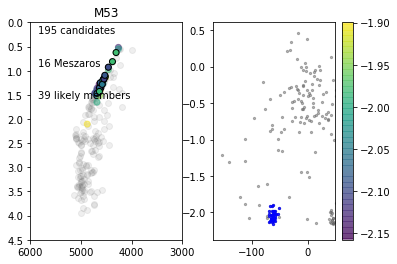

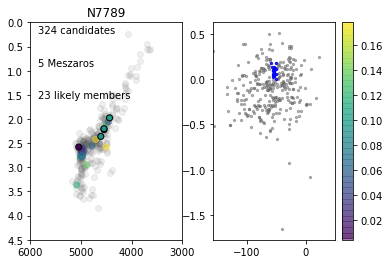

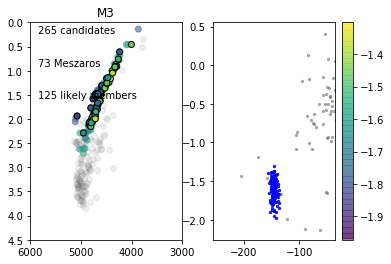

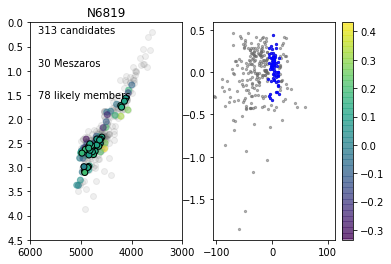

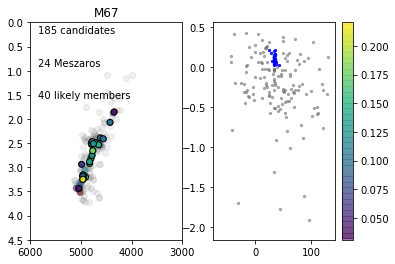

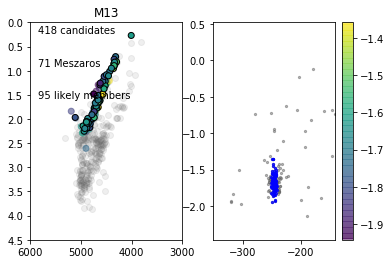

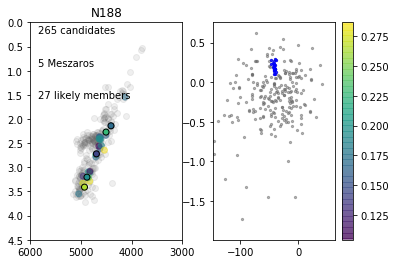

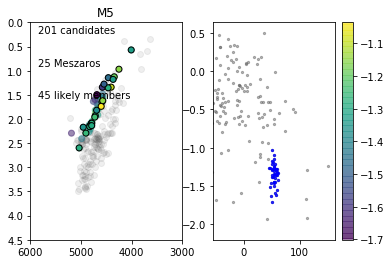

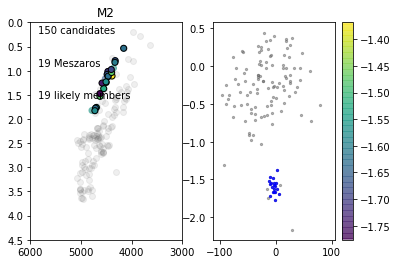

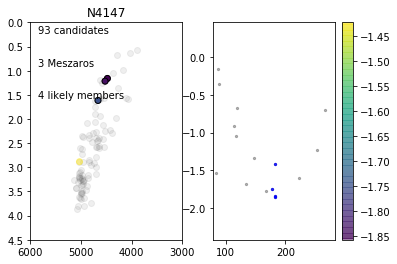

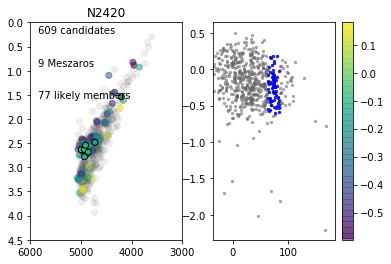

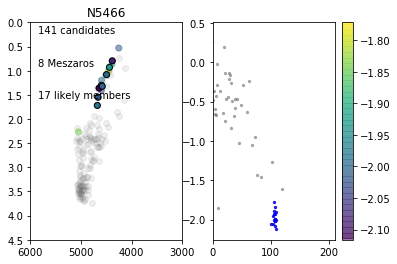

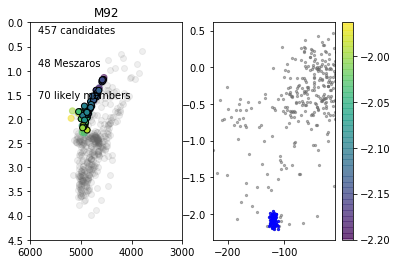

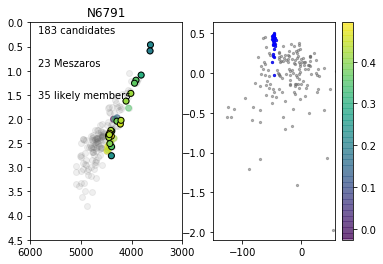

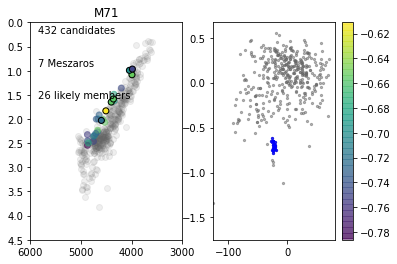

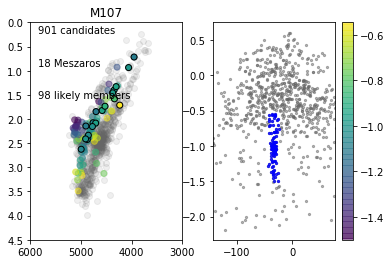

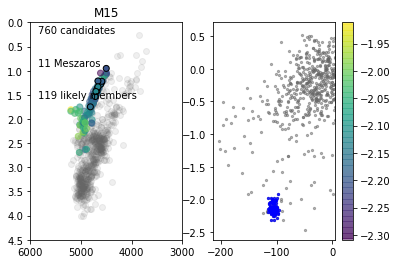

In [7]:
# OK, Take all the Meszaros members, and stars that are within the +/- tolerance of the VHELIO_AVG?

default_feh_tolerance = 0.50 # dex
default_vhelio_tolerance = 10.0 # km/s
vhelio_tolerances = {"N7789": 5, "N6791": 5, "M13": 5, "N188": 5, }
feh_tolerances = {"M67": 0.10, "N7789": 0.10, "M71": 0.20, "M92": 0.25, "N188": 0.10}

match_meszaros_member = np.zeros(len(data), dtype=bool)
match_likely_member = np.zeros(len(data), dtype=bool)

ignore_clusters = ("Pleiades", )

for cluster_name in set(common_clusters).difference(ignore_clusters):
    candidate = (fields == cluster_name) * np.isfinite(data["TEFF"])
    
    member_names = meszaros["_2MASS"][meszaros["Cluster"] == cluster_name]
    candidate_is_member = np.array([_[2:] in member_names for _ in data["APOGEE_ID"][candidate]])
    
    meszaros_member = np.zeros(candidate.shape, dtype=bool)
    meszaros_member[candidate] = candidate_is_member
    
    #assert candidate_is_member.sum() >= len(member_names)
    
    print("{} candidates: {}".format(cluster_name, candidate.sum()))
    print("{} Mezaros members: {}".format(cluster_name, meszaros_member.sum()))
    
    median_feh_members = np.median(data["FE_H"][meszaros_member])
    median_vhelio_members = np.median(apogee["VHELIO_AVG"][meszaros_member])
    
    feh_tolerance = feh_tolerances.get(cluster_name, default_feh_tolerance)
    vhelio_tolerance = vhelio_tolerances.get(cluster_name, default_vhelio_tolerance)
    likely_members = candidate \
                   * (np.abs(apogee["VHELIO_AVG"] - median_vhelio_members) < vhelio_tolerance) \
                   * (np.abs(data["FE_H"] - median_feh_members) < feh_tolerance)
    
    match_meszaros_member += meszaros_member
    match_likely_member += likely_members
    
    fig, axes = plt.subplots(1, 2)
    
    axes[0].set_title(cluster_name)
    scat = axes[0].scatter(data["TEFF"][candidate], data["LOGG"][candidate],
                           facecolor="#666666", alpha=0.1)
    
    _ = data["FE_H"][likely_members]
    if likely_members.sum() > 0:
        vmin, vmax = (min(_), max(_))
        scat = axes[0].scatter(data["TEFF"][likely_members], data["LOGG"][likely_members],
                               c=data["FE_H"][likely_members], alpha=0.5, vmin=vmin, vmax=vmax)
        _ = axes[0].scatter(data["TEFF"][meszaros_member], data["LOGG"][meszaros_member],
                            c=data["FE_H"][meszaros_member], vmin=vmin, vmax=vmax,
                            edgecolor="k")
        cbar = plt.colorbar(scat)
    
    axes[0].set_xlim(6000, 3000)
    axes[0].set_ylim(4.5, 0)
    
    axes[0].text(0.05, 0.95, "{} candidates".format(candidate.sum()), transform=axes[0].transAxes)
    axes[0].text(0.05, 0.80, "{} Meszaros".format(meszaros_member.sum()), transform=axes[0].transAxes)
    axes[0].text(0.05, 0.65, "{} likely members".format(likely_members.sum()), transform=axes[0].transAxes)
    
    axes[1].scatter(apogee["VHELIO_AVG"][candidate], data["FE_H"][candidate],
                   facecolor="#666666", alpha=0.5, s=5)
    axes[1].scatter(apogee["VHELIO_AVG"][likely_members], data["FE_H"][likely_members],
                   facecolor="b", alpha=0.75, s=5)
    
    if likely_members.sum() > 0:
        _ = apogee["VHELIO_AVG"][likely_members]
        axes[1].set_xlim(_.min() - 100, _.max() + 100)


Meszaros members: 395
Likely members: 937
Number of clusters: 17


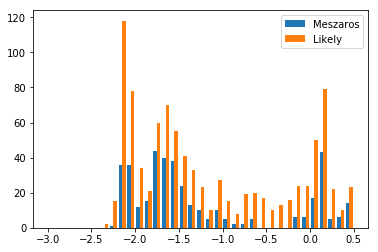

In [8]:
print("Meszaros members: {}".format(match_meszaros_member.sum()))
print("Likely members: {}".format(match_likely_member.sum()))

distilled_cluster_names = list(set(apogee["FIELD"][match_meszaros_member]))
print("Number of clusters: {}".format(len(distilled_cluster_names), distilled_cluster_names))

# [Fe/H] distributions?
fig, ax = plt.subplots()
bins = np.arange(-3, 0.6, 0.10)
_ = ax.hist([
        data["FE_H"][match_meszaros_member],
        data["FE_H"][match_likely_member]
    ], bins=bins, label=("Meszaros", "Likely"))
plt.legend()


In [11]:
# Join the two tables together, and provide indicator variables for membership in clusters.
for column_name in apogee.dtype.names:
    if column_name not in data.dtype.names:
        #print(column_name)
        
        if column_name in ("X_H", "X_H_ERR", "X_M", "X_M_ERR") \
        or column_name.endswith("_FE") or column_name.endswith("_FE_ERR") or column_name.endswith("_FE_FLAG"):
            prefix = "ASPCAP_"
        else:
            prefix = ""
        
        data[prefix + column_name] = apogee[column_name]

# Provide indicator variables.
membership_probability = np.zeros(len(data), dtype=float)
membership_probability[match_likely_member] = 0.5
membership_probability[match_meszaros_member] = 1.0

associations = data["FIELD"].copy()
associations[membership_probability == 0.0] = ""

data["ASSOCIATION_NAME"] = np.array(associations)
data["ASSOCIATION_PROB"] = np.array(membership_probability)

Available elemental abundances (25):
M_H, FE_H, C_H, CI_H, N_H, O_H, NA_H, MG_H, AL_H, SI_H, P_H, S_H, K_H, CA_H, TI_H, TIII_H, V_H, CR_H, MN_H, CO_H, NI_H, MIN_H, MAX_H, ASPCAP_X_H, SRC_H


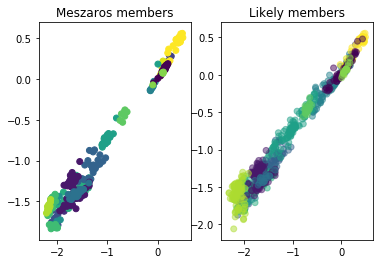

In [12]:
# [Fe/H] and [Mg/H]
fig, axes = plt.subplots(1, 2)
meszaros_indices = [distilled_cluster_names.index(field) for field in apogee["FIELD"][match_meszaros_member]]
likely_indices = [distilled_cluster_names.index(field) for field in apogee["FIELD"][match_likely_member]]
axes[0].scatter(
    data["FE_H"][match_meszaros_member], data["MG_H"][match_meszaros_member],
    c=meszaros_indices)
axes[0].set_title("Meszaros members")
axes[1].scatter(
    data["FE_H"][match_likely_member], data["MG_H"][match_likely_member],
    c=likely_indices, alpha=0.5)
axes[1].set_title("Likely members")

elements = [_ for _ in data.dtype.names if _.endswith("_H")]
print("Available elemental abundances ({}):\n{}".format(len(elements), ", ".join(elements)))

In [ ]:
data.write("../apogee-dr14-catalog.fits")